In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import pingouin as pg
from nilearn import plotting
from matplotlib.colors import LogNorm

from src import data

%matplotlib widget

!date -I

2024-03-18


In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

## Structural connectivity data description

- Distance-dependent consensus thresholds for generating group-representative structural brain networks (Betzel et al.)
- <https://github.com/GidLev/consensus-thresholding>

### PyTepFit

For these analyses we used structural neuroimaging data of 400 healthy young individuals (170  males; age range 21–35  years), taken from the Human Connectome Project (HCP) Dataset. DW-MRI preprocessing was run in Ubuntu 18.04 LTS, using tools from the FMRIB Software Library (FSL 5.0.3; https://www.fmrib.ox.ac.uk/fsl), MRtrix3 (https://www.MRtrix.readthedocs.io) and FreeSurfer 6.0. All images used were already corrected for motion via FSL’s EDDY as part of the HCP minimally-preprocessed diffusion pipeline. The multi-shell multi-tissue response function was estimated using constrained spherical deconvolution. T1-weighted (T1w) images, which were already coregistered to the b0 volume, were segmented using the FAST algorithm. Anatomically constrained tractography was employed to generate the initial tractogram with 10 million streamlines using second-order integration over fiber orientation distributions. Then, the spherical-deconvolution informed filtering of tractograms (SIFT2) methodology was applied, in order to provide more biologically accurate measures of fiber connectivity. Brain regions or network nodes were defined using the 200 region atlas of Schaefer et al., 2018, which was mapped to each individual’s FreeSurfer surfaces using spherical registration. This atlas additionally provides categorical assignments of regions into 7 canonical functional brain networks. Using this atlas in combination with the filtered streamlines, 200 × 200  two anatomical connectivity matrices were extracted, with matrix elements representing the number of streamlines and the fiber length connecting each pair of regions, respectively. These connectomes for the 400 HCP subjects were then averaged, yielding a healthy subject population-representative connectome matrix. *Finally, this matrix was prepared numerically for physiological network modelling by rescaling values by first taking the matrix Laplacian, and second by scalar division of all entries by the matrix norm, which ensures that the matrix is linearly stable (i.e. all eigenvalues have negative real part except one eigenvalue which was zero). The Laplacian sets each row sum (i.e. each node’s weighted in-degree) to zero by subtracting row sums from diagonal, and has been used often in previous whole-brain modelling research.*

- tu část kurzívou určitě nedělali v těch maticích, které mám k dispozici, takže to nejspíš byl samotný průměr?

### Enigma

Normative structural connectivity matrices were generated from preprocessed diffusion MRI data using MRtrix3. Anatomical constrained tractography was performed using different tissue types derived from the T1-weighted image, including cortical and subcortical gray matter, white matter, and cerebrospinal fluid. Multi-shell and multi-tissue response functions were estimated and constrained spherical deconvolution and intensity normalization were performed. The initial tractogram was generated with 40 million streamlines, with a maximum tract length of 250 and a fractional anisotropy cutoff of 0.06. Spherical-deconvolution informed filtering of tractograms (SIFT2) was applied to reconstruct whole-brain streamlines weighted by the cross-section multipliers. Reconstructed streamlines were mapped onto the 68 cortical and 14 subcortical (including hippocampus) regions to produce subject-specific structural connectivity matrices. The group-average normative structural connectome was defined using a distance-dependent thresholding procedure, which preserved the edge length distribution in individual patients, and was log transformed to reduce connectivity strength variance. As such, structural connectivity was defined by the number of streamlines between two regions (i.e., fiber density). <https://www.biorxiv.org/content/10.1101/2020.12.21.423838v3.full.pdf>

### Domhof

We used workflow developed in-house to reconstruct the SC from diffusion-weighted magnetic resonance imaging data, see https://github.com/inm7/vbc_dwmri. This rkflow consisted of four stages: (1) preprocessing of the diffusion-weighted images, (2) computing the whole-brain tractography, (3) transformation of the atlas images to the subject’s native space, and finally (4) reconstruction of the SC matrices. The pipeline can be regarded as a wrapper of functions included in the ANTs (Tustison et al., 2010), FreeSurfer, FSL and MRtrix3 software packages. Computations were performed n the JURECA high-performance computing cluster. 

When preprocessing the images, FreeSurfer functions were used to perform bias field correction, tissue segmentation, cortical (surface) reconstruction, volume-surface conversion and surface deformation on the T1-weighted images of the subjects. FreeSurfer functions were also used to perform head motion and eddy current distortion correction on the diffusion-weighted images, whereas MRtrix3 functions denoised them and erformed bias field orrection. The diffusion-weighted images were registered to the T1-weighted images by the linear and nonlinear transformation functions of FSL. Afterwards, tissue segmentation was also performed for the diffusion-weighted images. (2) Subsequently, the whole-brain tractography was computed on the basis of the diffusion-weighted images by using MRtrix3 functions. The response functions for spherical deconvolution were estimated using a multi-shell-multi-tissue constrained algorithm. Through these response functions, the fibre-oriented distributions could be determined from the diffusion-weighted images. The whole-brain tractography was completed via a second-order integration over these distributions by means of a probabilistic algorithm. We used the following tracking parameter settings: number of streamlines = 10M, step size = 0.625 mm, angle = 45o, min. length = 2.5 mm, max. length = 250 mm, FOD amplitude for terminating tract = 0.06, max. attempts per seed = 50, max. number of sampling trials = 1000 and down-sampling = 3 mm. (3) FSL function were used to linearly and nonlinearly transform the brain atlas images from the standard space to the subject’s native space. (4) Eventually, the MRtrix3 function tck2connectome was used to derive the number of streamlines and their average length for all pairs of parcels included in a particular parcellation. 

### Load structural (and functional) connectivity data

In [3]:
SC_W, SC_L, _ = data.load_pytepfit_sc()
SC_W_ENIGMA, _, FC_ENIGMA = data.load_enigma(parcellation="schaefer_200",reoreder='PyTepFit')
SC_L_ENIGMA = np.where(SC_W_ENIGMA>0,1/SC_W_ENIGMA,np.nan)
SC_W_dom, SC_L_dom, FC_dom = data.load_domhof_for_pytepfit()

centroids_file = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')

/tmp/ipykernel_29460/2726246981.py:3: RuntimeWarning: divide by zero encountered in divide
  SC_L_ENIGMA = np.where(SC_W_ENIGMA>0,1/SC_W_ENIGMA,np.nan)


In [4]:
color_mapping_by_yeonet = {'Default':'yellow', 'Limbic':'blue','SalVentAttn':'red',  'DorsAttn':'green','Vis':'purple','Cont':'orange', 'SomMot':'pink'}
idx_by_yeonet = []
ROI_colors = []

legend_patches = []
for c in color_mapping_by_yeonet:
    legend_patches.append(mpatches.Patch(color=color_mapping_by_yeonet[c], label=c))

labels = data.get_labels_from_file(centroids_file,"roi_name")

network = None
for i,l in enumerate(labels):
    n = l.split('_')[2]
    ROI_colors.append(color_mapping_by_yeonet[n])
    if n != network:
        idx_by_yeonet.append((n,i))
        network = n

# Euclidean distance

In [5]:
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")
centroids_csv = data.get_centroids_from_file(centroids_file,"geom_csv")

ED_mne = data.roi_distances_from_centroids(centroids_mne)
ED_csv = data.roi_distances_from_centroids(centroids_csv)

In [6]:
def plot_adjacency_matrix(matrix,ax,title,subnets_idx=idx_by_yeonet,norm=None,mask=None):

    g =sns.heatmap(matrix,ax=ax,square=True,cbar=False,yticklabels=False, xticklabels=False,cmap='gray',norm=norm,mask=mask)
    g.set_facecolor('k')
    ax.set_title(title)

    subnet_0,id_start_0 = subnets_idx[0]
    for subnet,id_start in subnets_idx[1:]:
        ax.add_patch(mpatches.Rectangle((id_start_0, id_start_0),
                                          id_start-id_start_0, # Width
                                          id_start-id_start_0, # Height
                                          facecolor="none",
                                          edgecolor=color_mapping_by_yeonet[subnet_0],
                                          linewidth=1))
        subnet_0,id_start_0 = subnet,id_start

    ax.add_patch(mpatches.Rectangle((id_start_0, id_start_0),
                                          200-id_start_0, # Width
                                          200-id_start_0, # Height
                                          facecolor="none",
                                          edgecolor=color_mapping_by_yeonet[subnet_0],
                                          linewidth=1))

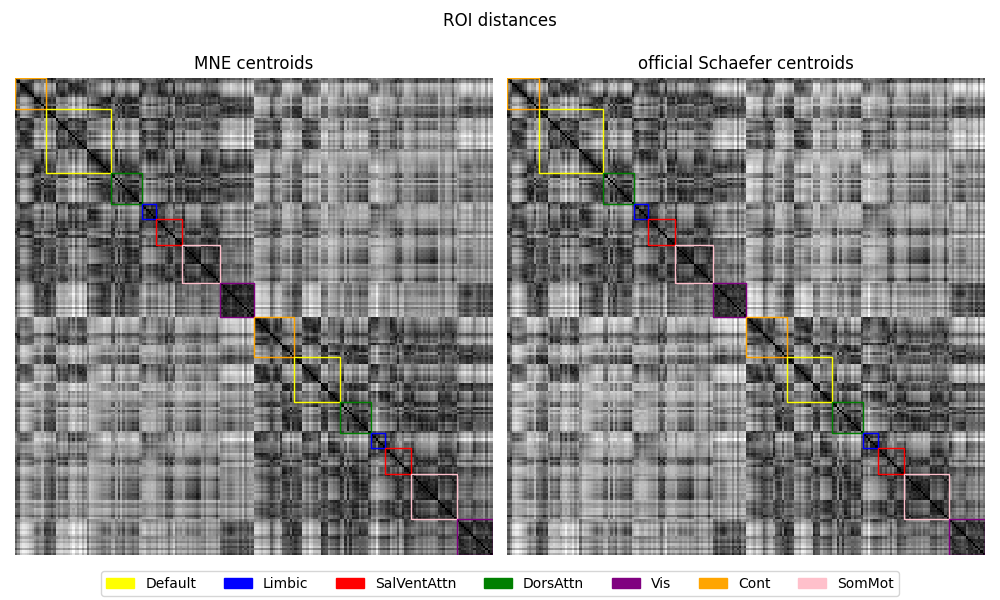

In [7]:
fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,6),sharey=True,sharex=True)
fig.suptitle("ROI distances")
fig.legend(handles=legend_patches,loc='lower center', ncols=7,bbox_to_anchor=(0,-0.005,1,1))
plot_adjacency_matrix(ED_mne,axs[0],"MNE centroids")
plot_adjacency_matrix(ED_csv,axs[1],"official Schaefer centroids")


In [8]:
ED = pd.DataFrame({"MNE":ED_mne.flatten(),"Schaefer CSV":ED_csv.flatten()})
pg.pairwise_corr(ED,method="spearman")

X             Y    method alternative      n         r         CI95%  \
0  MNE  Schaefer CSV  spearman   two-sided  40000  0.988295  [0.99, 0.99]   

   p-unc  power  
0    0.0    1.0

In [9]:
pg.pairwise_corr(ED)

X             Y   method alternative      n         r         CI95%  \
0  MNE  Schaefer CSV  pearson   two-sided  40000  0.987821  [0.99, 0.99]   

   p-unc BF10  power  
0    0.0  nan    1.0

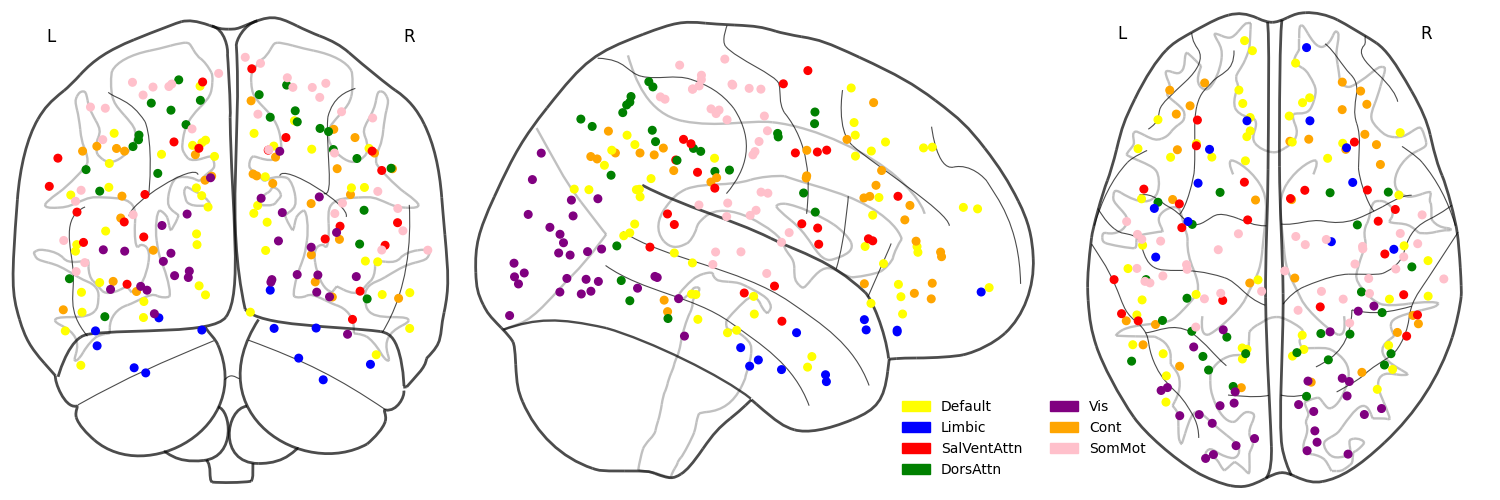

In [10]:
n_roi = len(centroids_mne)
zero_adjacency = np.zeros((n_roi,n_roi))

fig = plt.figure()
plt.legend(handles=legend_patches,loc='upper right', bbox_to_anchor=(0.835, 0.15, 0,0),frameon=False,ncols=2) # (x, y, width, height)

plt.box(False)
# Selecting the axis-X making the bottom and top axes False. 
plt.tick_params(axis='x', which='both', bottom=False, 
                top=False, labelbottom=False) 
  
# Selecting the axis-Y making the right and left axes False 
plt.tick_params(axis='y', which='both', right=False, 
                left=False, labelleft=False) 
  
# Iterating over all the axes in the figure 
# and make the Spines Visibility as False 
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 

plotting.plot_connectome(zero_adjacency,centroids_mne,node_size=30,figure=fig,node_color=ROI_colors)

# Structural connectivity - weights

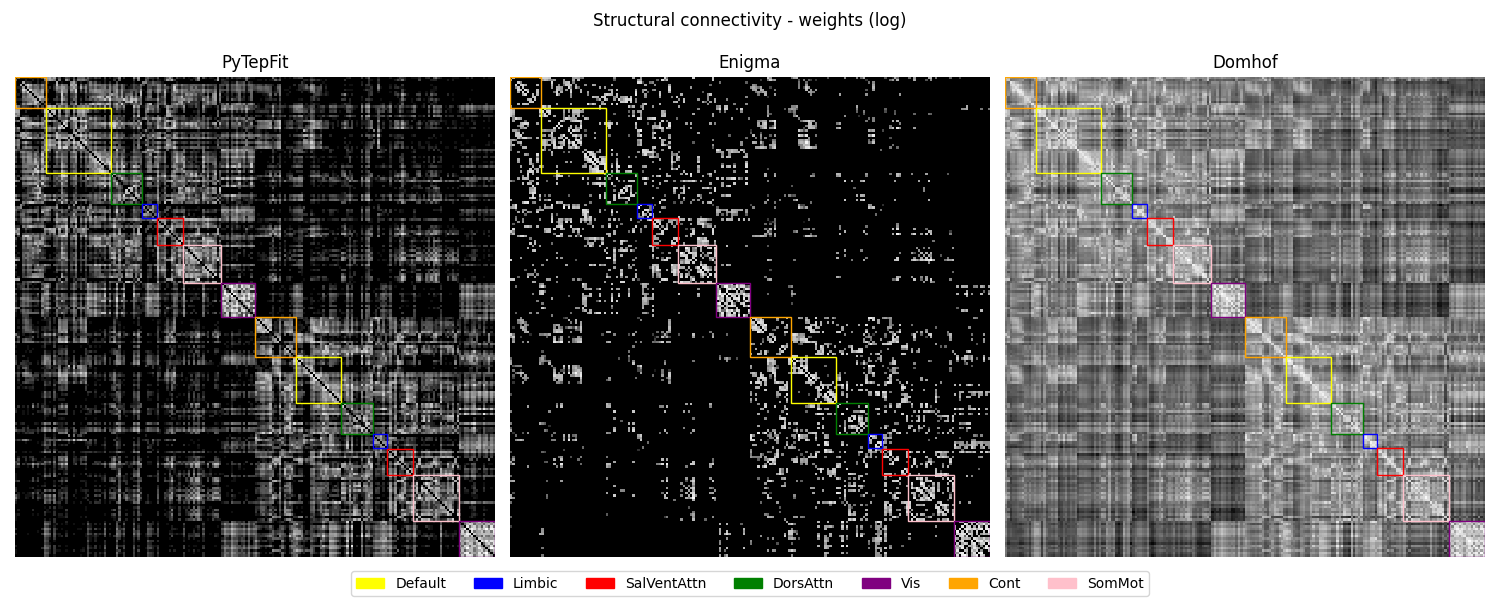

In [11]:
fig, axs = plt.subplots(1, 3, tight_layout=True,figsize=(15,6),sharey=True,sharex=True)
fig.suptitle("Structural connectivity - weights (log)")
fig.legend(handles=legend_patches,loc='lower center', ncols=7,bbox_to_anchor=(0,-0.005,1,1))
plot_adjacency_matrix(SC_W,axs[0],"PyTepFit",norm=LogNorm(),mask=SC_W==0)
plot_adjacency_matrix(SC_W_ENIGMA,axs[1],"Enigma",mask=SC_W_ENIGMA==0)
plot_adjacency_matrix(SC_W_dom,axs[2],"Domhof",norm=LogNorm())

In [12]:
SC_weights = pd.DataFrame({"PyTepFit":SC_W.flatten(),"Enigma":SC_W_ENIGMA.flatten(),"Domhof":SC_W_dom.flatten()})
pg.pairwise_corr(SC_weights,method="spearman")

X       Y    method alternative      n         r         CI95%  \
0  PyTepFit  Enigma  spearman   two-sided  40000  0.483942  [0.48, 0.49]   
1  PyTepFit  Domhof  spearman   two-sided  40000  0.834412  [0.83, 0.84]   
2    Enigma  Domhof  spearman   two-sided  40000  0.508299   [0.5, 0.52]   

   p-unc  power  
0    0.0    1.0  
1    0.0    1.0  
2    0.0    1.0

In [13]:
pg.pairwise_corr(SC_weights)

X       Y   method alternative      n         r         CI95%  \
0  PyTepFit  Enigma  pearson   two-sided  40000  0.520906  [0.51, 0.53]   
1  PyTepFit  Domhof  pearson   two-sided  40000  0.548002  [0.54, 0.55]   
2    Enigma  Domhof  pearson   two-sided  40000  0.431184  [0.42, 0.44]   

   p-unc BF10  power  
0    0.0  inf    1.0  
1    0.0  inf    1.0  
2    0.0  inf    1.0

In [14]:
m1 = np.log(SC_W)/np.nanmax(np.log(SC_W),axis=None)
m1 = np.where(m1 < 0,np.nan,m1)
m2 = SC_W_ENIGMA/np.nanmax(SC_W_ENIGMA,axis=None)
m3 = np.log(SC_W_dom)/np.nanmax(np.log(SC_W_dom),axis=None)

m1_pivot = data.find_pivot_to_keep_xpercent_edges(m1,percent=0.95)
m2_pivot = data.find_pivot_to_keep_xpercent_edges(m2,percent=0.95)
m3_pivot = data.find_pivot_to_keep_xpercent_edges(m3,percent=0.95)

/tmp/ipykernel_29460/2118558701.py:1: RuntimeWarning: divide by zero encountered in log
  m1 = np.log(SC_W)/np.nanmax(np.log(SC_W),axis=None)


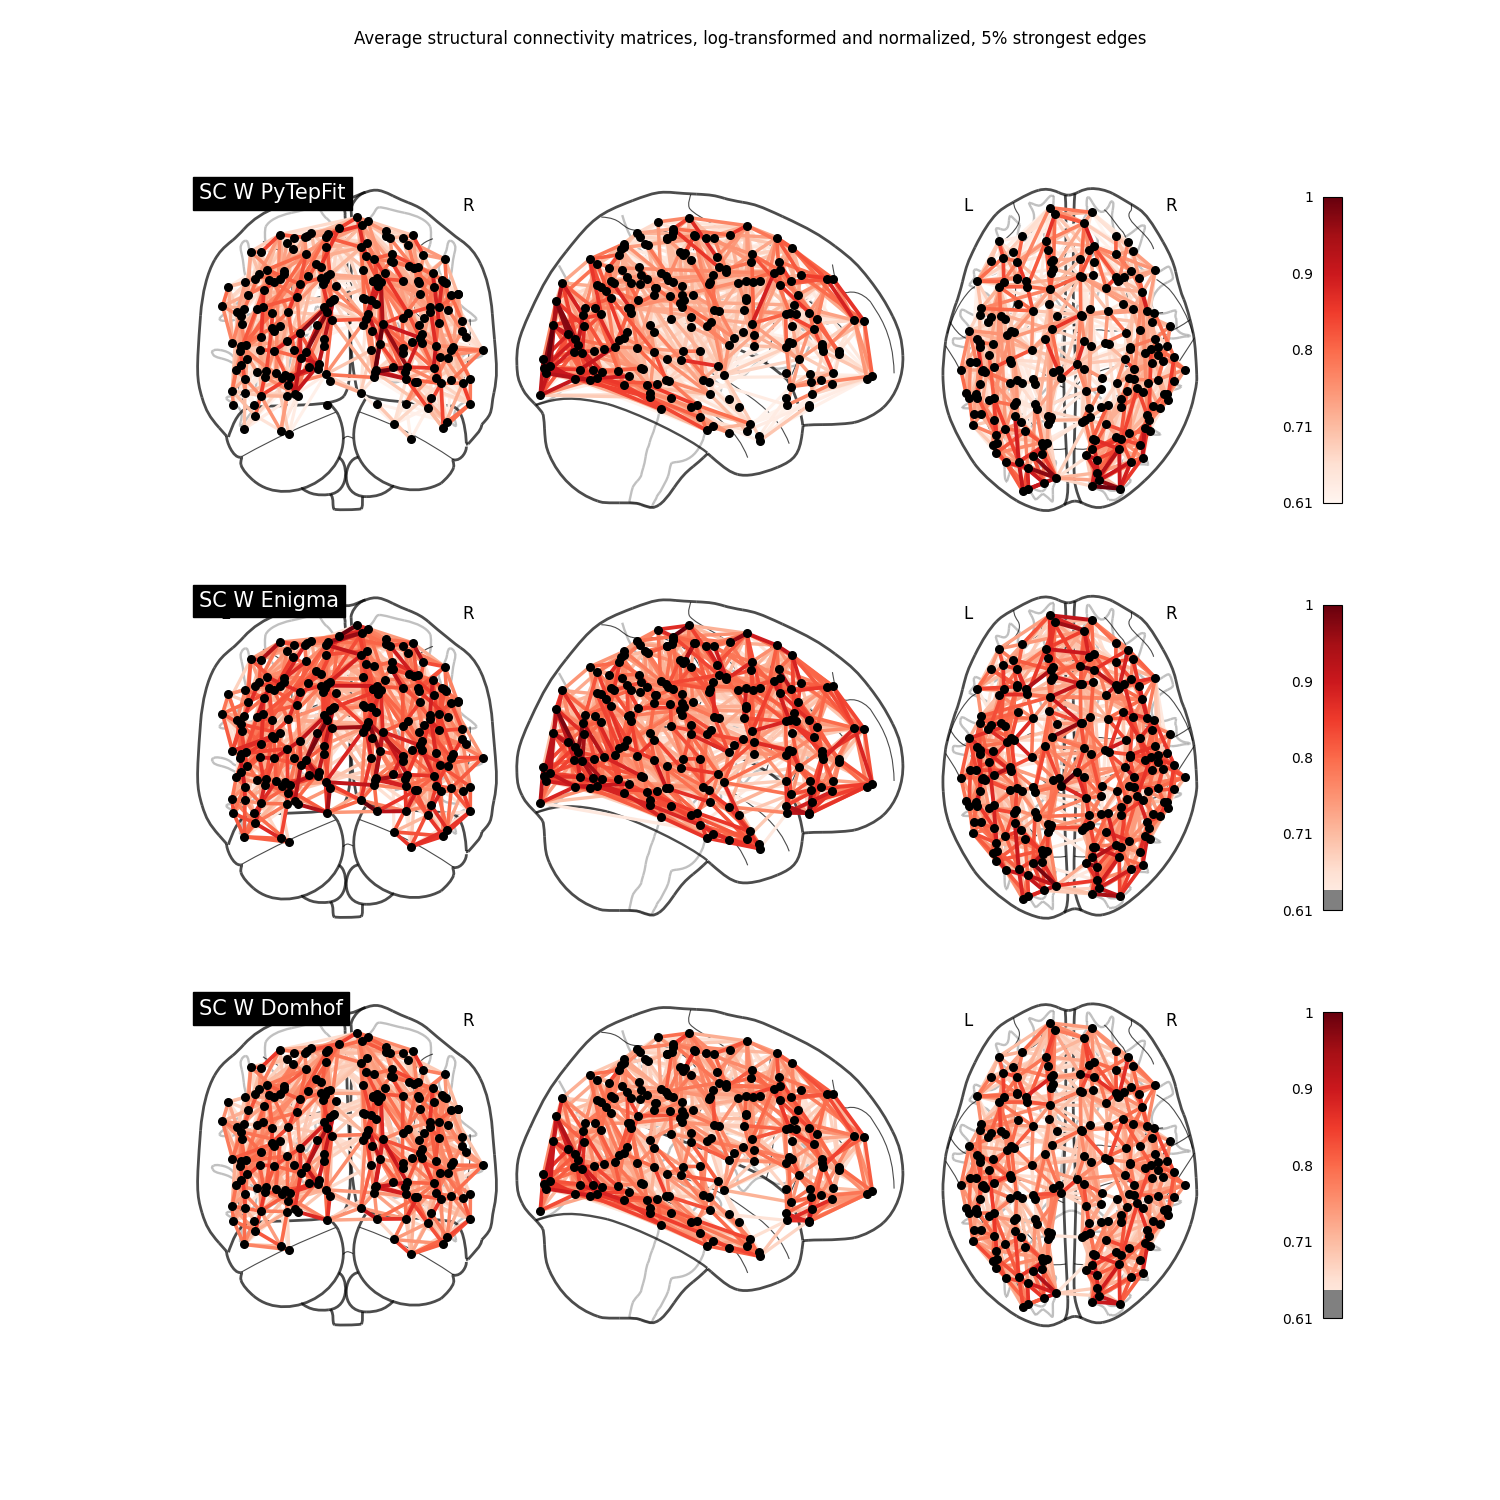

In [15]:
fig, ax= plt.subplots(3,1,figsize=(15,15),sharex=True,sharey=True)
minimum=min([m1_pivot,m2_pivot,m3_pivot])
maximum=1
fig.suptitle("Average structural connectivity matrices, log-transformed and normalized, 5% strongest edges")

plotting.plot_connectome(m1,centroids_mne,edge_threshold=m1_pivot,axes=ax[0],node_color="k",node_size=30,title="SC W PyTepFit",colorbar=True,edge_vmin=minimum,edge_vmax=maximum,edge_cmap='Reds')
plotting.plot_connectome(m2,centroids_mne,edge_threshold=m2_pivot,axes=ax[1],node_color="k",node_size=30,title="SC W Enigma",colorbar=True,edge_vmin=minimum,edge_vmax=maximum,edge_cmap='Reds')
plotting.plot_connectome(m3,centroids_mne,edge_threshold=m3_pivot,axes=ax[2],node_color="k",node_size=30,title="SC W Domhof",colorbar=True,edge_vmin=minimum,edge_vmax=maximum,edge_cmap='Reds')

In [16]:
SC_weights = pd.DataFrame({"PyTepFit":m1.flatten(),"Enigma":m2.flatten(),"Domhof":m3.flatten()})
pg.pairwise_corr(SC_weights,method="spearman")

X       Y    method alternative      n         r         CI95%  \
0  PyTepFit  Enigma  spearman   two-sided  27722  0.529747  [0.52, 0.54]   
1  PyTepFit  Domhof  spearman   two-sided  27722  0.835317  [0.83, 0.84]   
2    Enigma  Domhof  spearman   two-sided  40000  0.508299   [0.5, 0.52]   

   p-unc  power  
0    0.0    1.0  
1    0.0    1.0  
2    0.0    1.0

# Structural connectivity - lengths

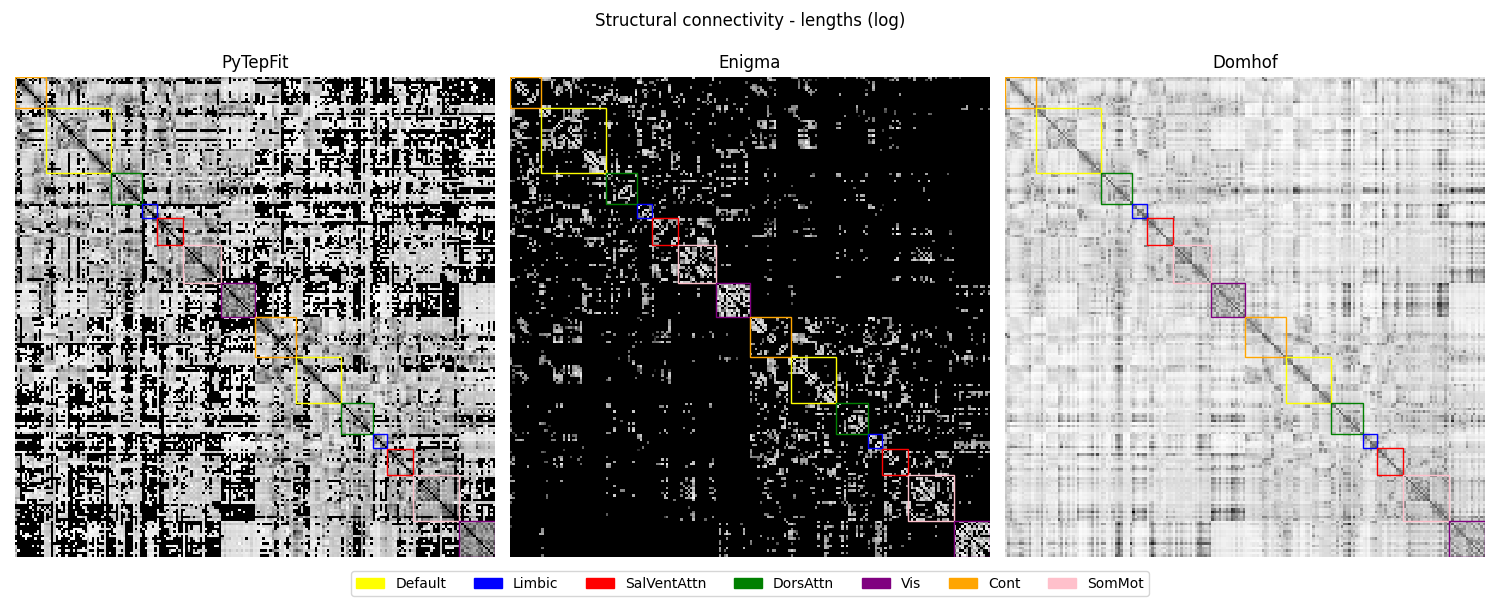

In [17]:
fig, axs = plt.subplots(1, 3, tight_layout=True,figsize=(15,6),sharey=True,sharex=True)
fig.suptitle("Structural connectivity - lengths (log)")
fig.legend(handles=legend_patches,loc='lower center', ncols=7,bbox_to_anchor=(0,-0.005,1,1))
plot_adjacency_matrix(SC_L,axs[0],"PyTepFit",norm=LogNorm(),mask=SC_W==0)
plot_adjacency_matrix(SC_W_ENIGMA,axs[1],"Enigma",mask=SC_W_ENIGMA==0)
plot_adjacency_matrix(SC_L_dom,axs[2],"Domhof",norm=LogNorm())

In [18]:
SC_lengths = pd.DataFrame({"PyTepFit":SC_L.flatten(),"Enigma":SC_L_ENIGMA.flatten(),"Domhof":SC_L_dom.flatten()})
pg.pairwise_corr(SC_lengths,method="spearman")

X       Y    method alternative      n         r         CI95%  \
0  PyTepFit  Enigma  spearman   two-sided   4722  0.573469  [0.55, 0.59]   
1  PyTepFit  Domhof  spearman   two-sided  27722  0.777570  [0.77, 0.78]   
2    Enigma  Domhof  spearman   two-sided   4806  0.598287  [0.58, 0.62]   

   p-unc  power  
0    0.0    1.0  
1    0.0    1.0  
2    0.0    1.0

In [19]:
pg.pairwise_corr(SC_lengths,method="pearson")

X       Y   method alternative      n         r         CI95%  \
0  PyTepFit  Enigma  pearson   two-sided   4722  0.301478  [0.28, 0.33]   
1  PyTepFit  Domhof  pearson   two-sided  27722  0.788650  [0.78, 0.79]   
2    Enigma  Domhof  pearson   two-sided   4806  0.277187   [0.25, 0.3]   

           p-unc       BF10  power  
0  8.331544e-100   7.65e+95    1.0  
1   0.000000e+00        inf    1.0  
2   1.662203e-85  4.159e+81    1.0

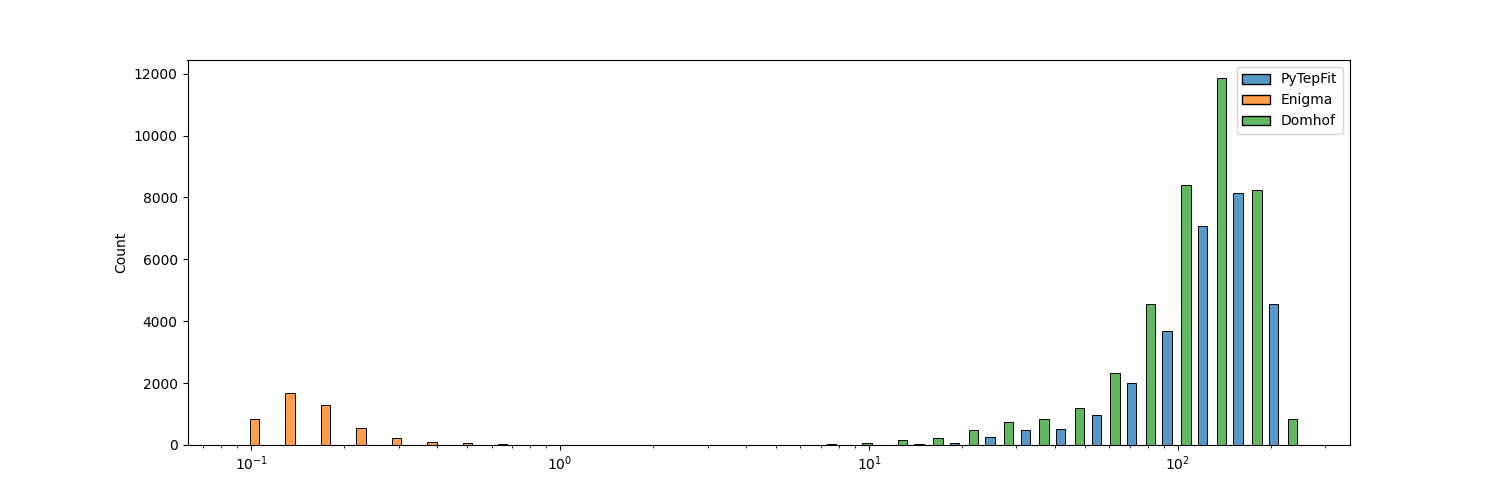

In [20]:
plt.figure()
sns.histplot(SC_lengths,bins = 30, multiple="dodge", shrink=.8,log_scale=True)
plt.show()

# Functional connectivity

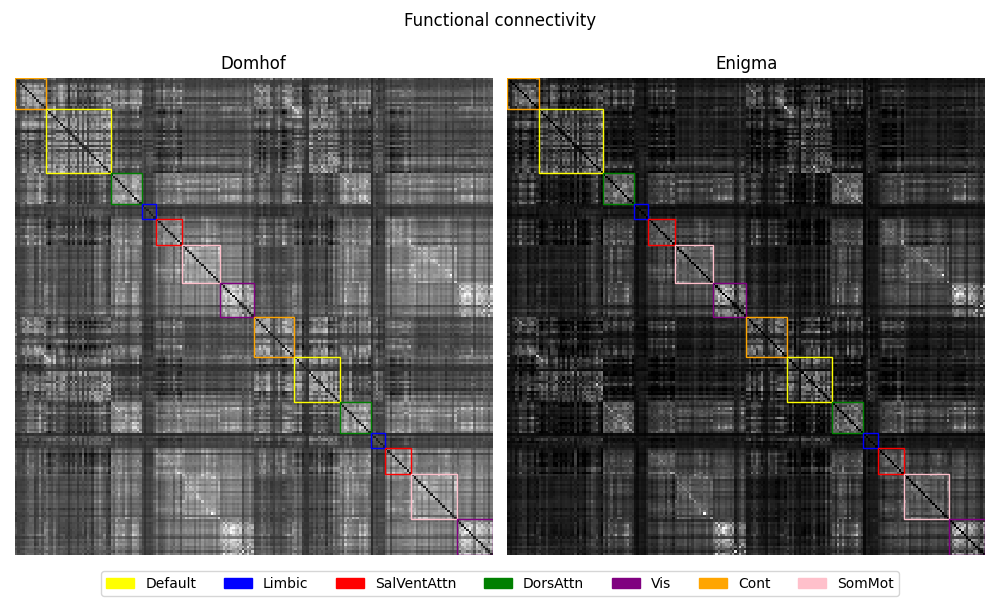

In [21]:
fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,6),sharey=True,sharex=True)
fig.suptitle("Functional connectivity")
fig.legend(handles=legend_patches,loc='lower center', ncols=7,bbox_to_anchor=(0,-0.005,1,1))
plot_adjacency_matrix(FC_dom,axs[0],"Domhof")
plot_adjacency_matrix(FC_ENIGMA,axs[1],"Enigma")

In [22]:
FC = pd.DataFrame({"Enigma":FC_ENIGMA.flatten(),"Domhof":FC_dom.flatten()})
pg.pairwise_corr(FC,method="spearman")

X       Y    method alternative      n         r         CI95%  p-unc  \
0  Enigma  Domhof  spearman   two-sided  40000  0.921039  [0.92, 0.92]    0.0   

   power  
0    1.0

In [23]:
pg.pairwise_corr(FC)

X       Y   method alternative      n         r         CI95%  p-unc  \
0  Enigma  Domhof  pearson   two-sided  40000  0.921401  [0.92, 0.92]    0.0   

  BF10  power  
0  inf    1.0

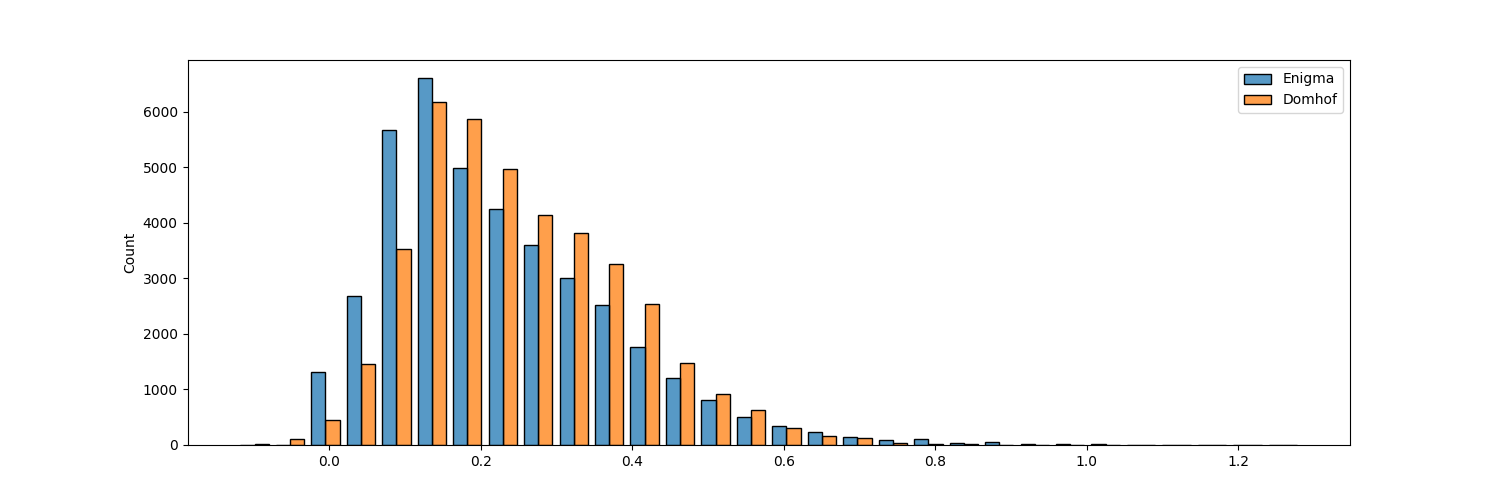

In [24]:
plt.figure()
sns.histplot(FC,bins = 30, multiple="dodge", shrink=.8)
plt.show()

In [25]:
pivot20_ENIGMA = data.find_pivot_to_keep_xpercent_edges(FC_ENIGMA,percent=0.8)
pivot20_dom = data.find_pivot_to_keep_xpercent_edges(FC_dom,percent=0.8)

FC_ENIGMA_20 = np.where(FC_ENIGMA > pivot20_ENIGMA,FC_ENIGMA,np.nan)
FC_dom_20 = np.where(FC_dom > pivot20_dom,FC_dom,np.nan)

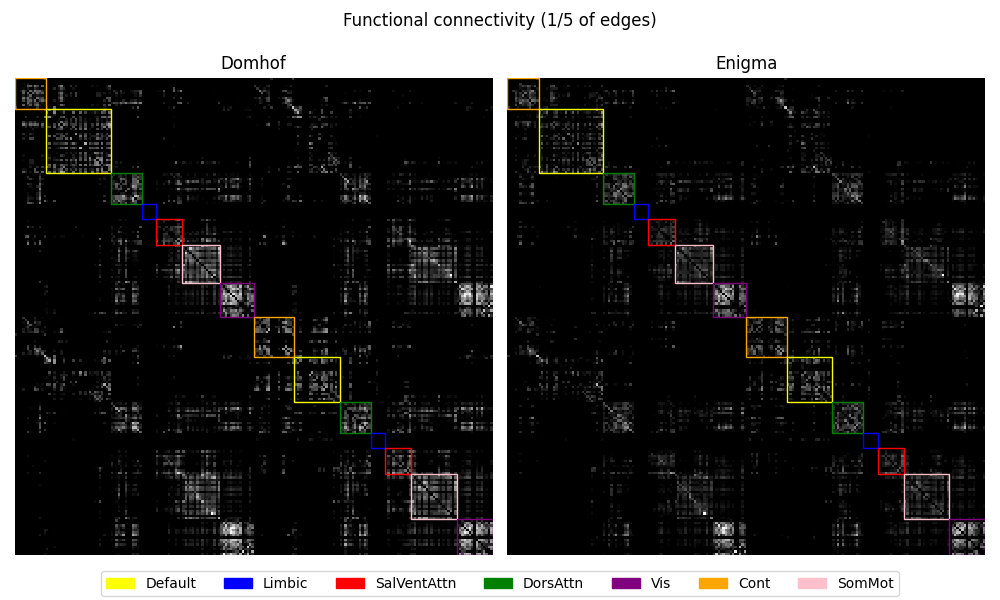

In [26]:
fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,6),sharey=True,sharex=True)
fig.suptitle("Functional connectivity (1/5 of edges)")
fig.legend(handles=legend_patches,loc='lower center', ncols=7,bbox_to_anchor=(0,-0.005,1,1))
plot_adjacency_matrix(FC_dom_20,axs[0],"Domhof")
plot_adjacency_matrix(FC_ENIGMA_20,axs[1],"Enigma")

In [27]:
FC_20percent = pd.DataFrame({"Enigma":FC_ENIGMA_20.flatten(),"Domhof":FC_dom_20.flatten()})
pg.pairwise_corr(FC,method="spearman")

X       Y    method alternative      n         r         CI95%  p-unc  \
0  Enigma  Domhof  spearman   two-sided  40000  0.921039  [0.92, 0.92]    0.0   

   power  
0    1.0

In [28]:
pg.pairwise_corr(FC)

X       Y   method alternative      n         r         CI95%  p-unc  \
0  Enigma  Domhof  pearson   two-sided  40000  0.921401  [0.92, 0.92]    0.0   

  BF10  power  
0  inf    1.0

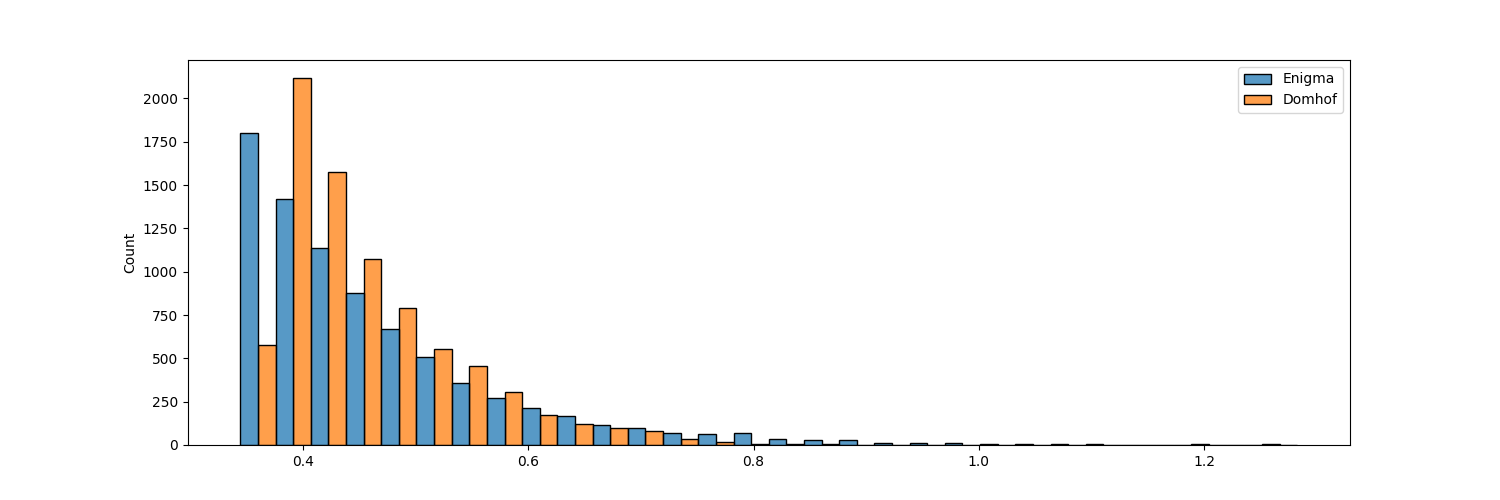

In [29]:
plt.figure()
sns.histplot(FC_20percent,bins = 30, multiple="dodge")
plt.show()

In [30]:
minimum = FC_20percent.min(axis=None)
maximum = FC_20percent.max(axis=None)

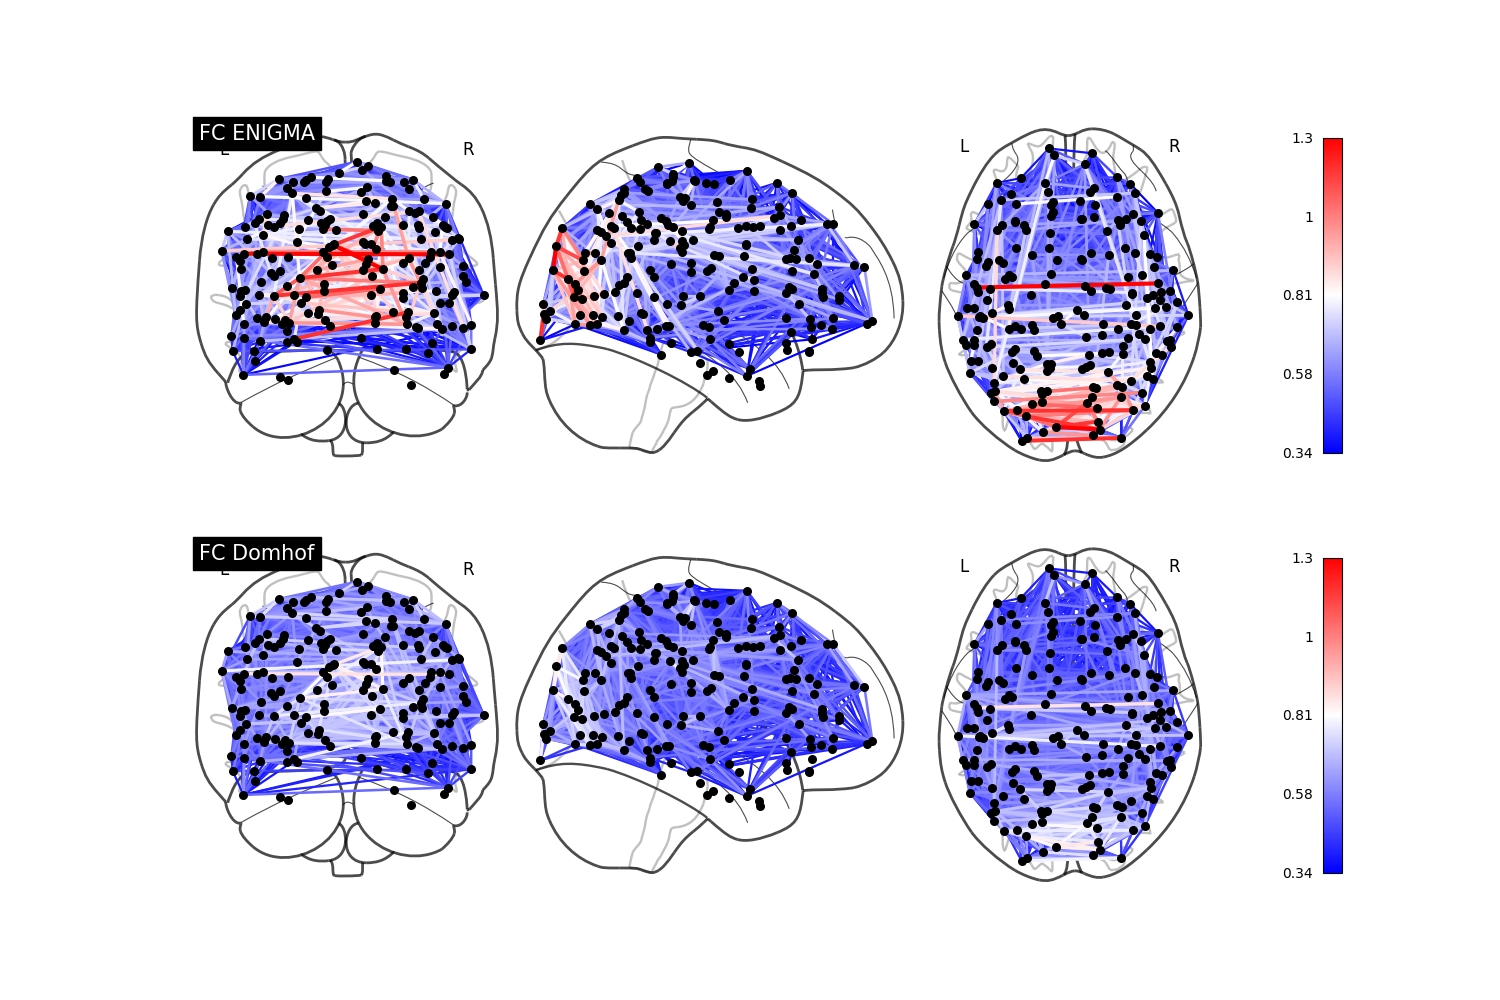

In [31]:
fig, ax= plt.subplots(2,1,figsize=(15,10))
plotting.plot_connectome(FC_ENIGMA_20,centroids_mne,node_color="k",node_size=30,axes=ax[0],edge_vmin=minimum, edge_vmax=maximum,title="FC ENIGMA",colorbar=True)
plotting.plot_connectome(FC_dom_20,centroids_mne,node_color="k",node_size=30,axes=ax[1],edge_vmin=minimum, edge_vmax=maximum,title="FC Domhof",colorbar=True)